Total Number of Duplicate Rows: 25876
ArrivalDateMonth: 12 unique values
Meal: 4 unique values
MarketSegment: 7 unique values
DistributionChannel: 4 unique values
ReservedRoomType: 7 unique values
AssignedRoomType: 8 unique values
DepositType: 3 unique values
CustomerType: 4 unique values
ReservationStatus: 3 unique values
['num__LeadTime' 'num__ArrivalDateYear' 'num__ArrivalDateMonth'
 'num__ArrivalDateWeekNumber' 'num__ArrivalDateDayOfMonth'
 'num__StaysInWeekendNights' 'num__StaysInWeekNights' 'num__Adults'
 'num__Children' 'num__Babies' 'num__Meal' 'num__MarketSegment'
 'num__DistributionChannel' 'num__IsRepeatedGuest'
 'num__PreviousCancellations' 'num__PreviousBookingsNotCanceled'
 'num__ReservedRoomType' 'num__AssignedRoomType' 'num__BookingChanges'
 'num__DepositType' 'num__DaysInWaitingList' 'num__CustomerType'
 'num__ADR' 'num__RequiredCarParkingSpaces' 'num__TotalOfSpecialRequests'
 'num__TotalStay' 'num__SpendingPerPerson' 'num__GroupType'
 'num__BookingUrgency' 'num__HighD

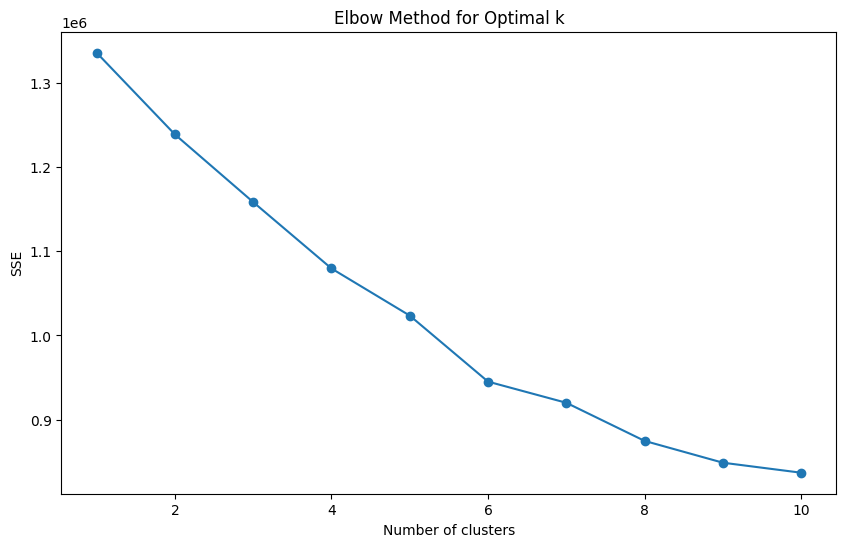

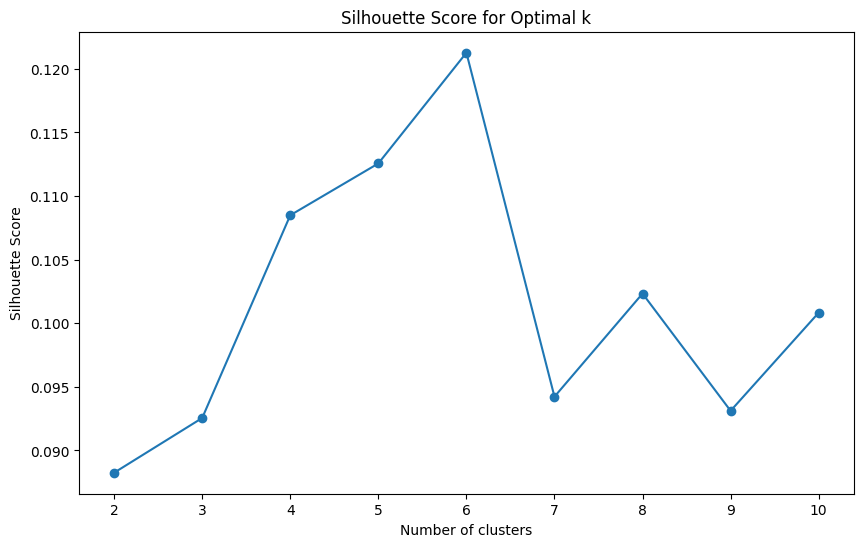

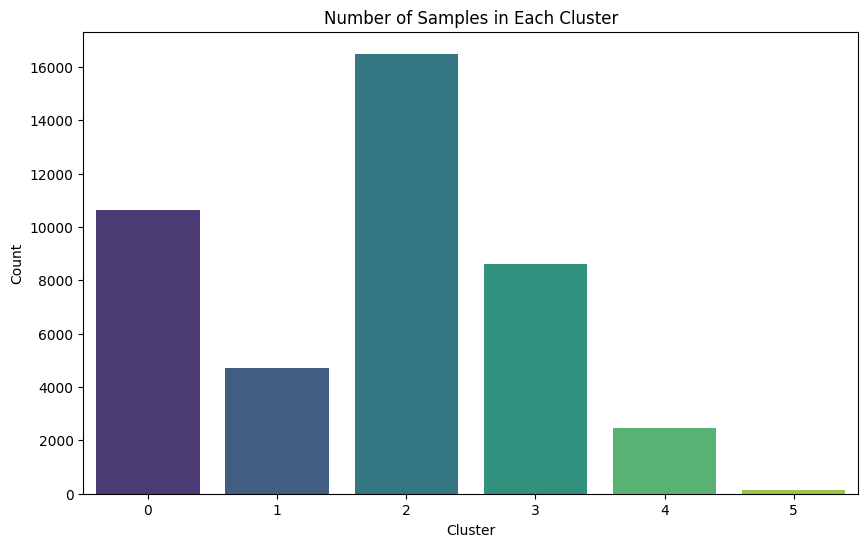

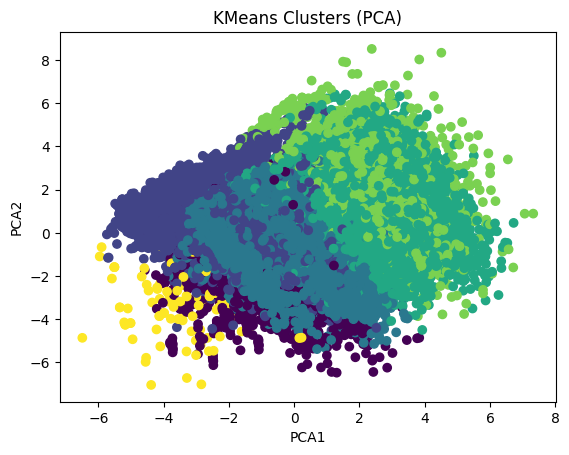

Silhouette Score: 0.12127118931469655
Davies-Bouldin Score: 2.0100888769790894
Calinski-Harabasz Score: 3564.879239319026
Noise Ratio: 0.0


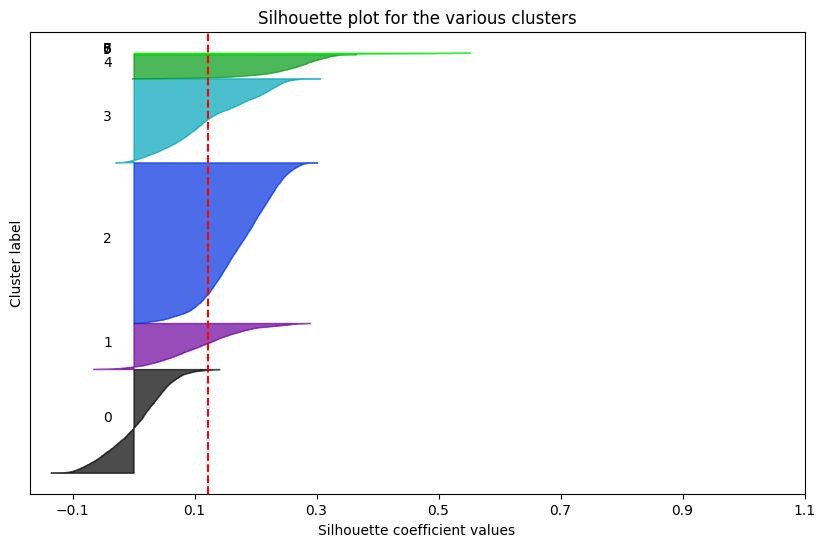

In [1]:
# Run Initial Preparation Notebook
# Run ML Preparation Notebook
# Run KMeans Model Building Notebook
%run app1_cust_seg_ml1_kmeans.ipynb

In [2]:
# Import Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#### 1. HyperParameter Tuning with Grid Search

In [3]:
# HyperParameter Grid
param_grid = {
    #'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500, 1000],
    'n_init': [10, 20, 30]
}

def silhouette_scorer(estimator, df):
    labels = estimator.fit_predict(df)
    return silhouette_score(df, labels)

grid = GridSearchCV(
    estimator=KMeans(n_clusters=6, random_state=42),
    param_grid=param_grid,
    scoring=make_scorer(silhouette_scorer),
    cv=3
)

grid.fit(transformed_df)
print("Best Parameters:", grid.best_params_) 

Best Parameters: {'init': 'k-means++', 'max_iter': 300, 'n_init': 10}


In [4]:
# Best Estimator
best_kmeans = grid.best_estimator_

# Train model
best_kmeans.fit(transformed_df)

# Clusters
clusters = best_kmeans.labels_

print("Cluster Labels:", clusters)

Cluster Labels: [3 3 3 ... 1 4 4]


In [5]:
# Add Clusters to the Dataset
transformed_df["Cluster"] = clusters

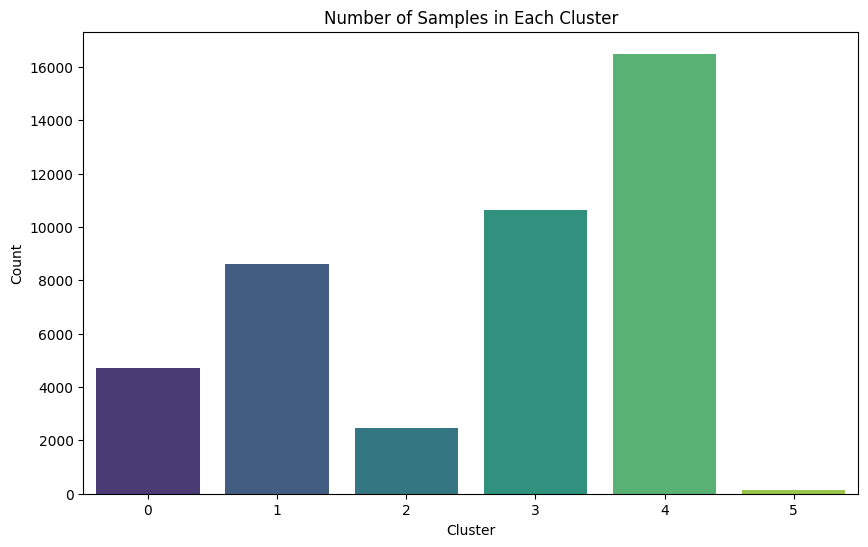

In [6]:
# Countplot for visualizing the number of samples in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=transformed_df, palette='viridis')
plt.title('Number of Samples in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

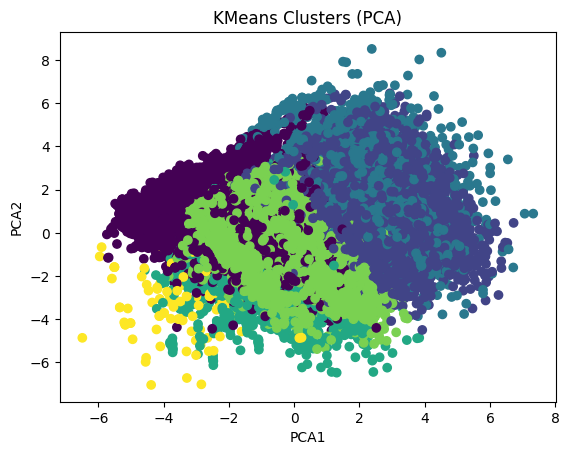

In [7]:
from sklearn.decomposition import PCA

# Dimensionally Reduction with PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(transformed_df.drop('Cluster', axis=1))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('KMeans Clusters (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [8]:
# Calculate silhouette score
silhouette_avg = silhouette_score(transformed_df.drop('Cluster', axis=1), y_pred)
print(f'Silhouette Score: {silhouette_avg}')

# Calculate Davies-Bouldin score
davies_bouldin_avg = davies_bouldin_score(transformed_df.drop('Cluster', axis=1), y_pred)
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')

# Calculate Calinski-Harabasz score
calinski_harabasz_avg = calinski_harabasz_score(transformed_df.drop('Cluster', axis=1), y_pred)
print(f'Calinski-Harabasz Score: {calinski_harabasz_avg}')

# Calculate noise ratio (assuming noise points are labeled as -1)
noise_ratio = (y_pred == -1).sum() / len(y_pred)
print(f'Noise Ratio: {noise_ratio}')

Silhouette Score: 0.12127118931469655
Davies-Bouldin Score: 2.0100888769790894
Calinski-Harabasz Score: 3564.879239319026
Noise Ratio: 0.0


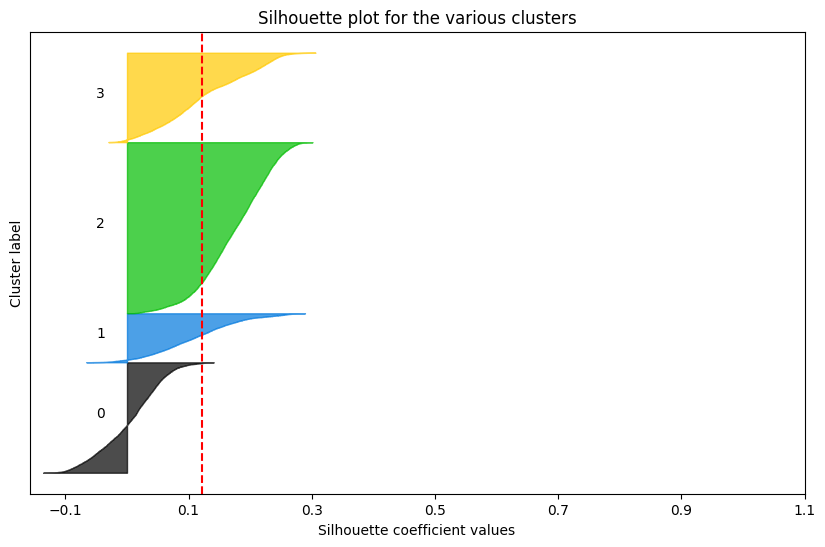

In [9]:
from sklearn.metrics import silhouette_samples
import numpy as np

# Silhouette scores for each sample
sample_silhouette_values = silhouette_samples(transformed_df.drop('Cluster', axis=1), y_pred)

# Plotting silhouette diagram
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
for i in range(4):  # Number of clusters
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / 4)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette plot for the various clusters")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
plt.show()